# Railway Tracking Model
## Import modules

In [41]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
import cv2

## Set properties

In [42]:
img_shape = (256,256,3)
img_path = "./test.jpg"
saved_weight = "./railway_detection/weights.hdf5"
batch_size = 1

In [43]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

## Build model

In [44]:
inputs = layers.Input(shape=img_shape) # 256
encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
center = conv_block(encoder4_pool, 1024) # center
decoder4 = decoder_block(center, encoder4, 512) # 16
decoder3 = decoder_block(decoder4, encoder3, 256) # 32
decoder2 = decoder_block(decoder3, encoder2, 128) # 64
decoder1 = decoder_block(decoder2, encoder1, 64) # 128
decoder0 = decoder_block(decoder1, encoder0, 32) # 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
#model = models.Model(inputs=[inputs], outputs=[outputs])


In [45]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile and load model

In [49]:
model = models.load_model('./railway_detection/model.h5',custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()
print('model compiled')

#from keras.models import model_from_json
#json_file = open("models/model.json", "r")
#loaded_model_json = json_file.read()
#json_file.close()
    #loaded_model = model_from_json(loaded_model_json)
#print('model loaded')

#model.load_weights(saved_weight)
print('weight loaded')

#model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})

W0829 16:07:37.541292 14096 deprecation.py:506] From C:\Users\김민석\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0829 16:07:37.542288 14096 deprecation.py:506] From C:\Users\김민석\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0829 16:07:37.544282 14096 deprecation.py:506] From C:\Users\김민석\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.in

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Show result

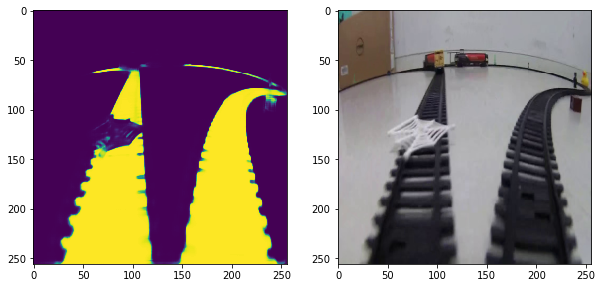

In [63]:
test_img =mpimg.imread(img_path)
squared_img = cv2.resize(test_img, dsize=(256, 256), interpolation=cv2.INTER_AREA) /255
input_img= np.expand_dims(squared_img, axis=0)
predicted_label = model.predict(input_img)[0]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(predicted_label[:, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(squared_img)

# Obstacle Detection Model
## Import module

In [51]:
# Import packages
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

In [52]:
# This is needed since the notebook is stored in the object_detection folder.
#sys.path.append('C:\\tensorflow1\\models\\research\\object_detection')

In [53]:
# Import utilites
print(sys.path)
from object_detection.utils import label_map_util
import visualization_utils as vis_util
print(vis_util.__file__)


['C:\\tensorflow1\\models\\research\\object_detection', 'C:\\ProgramData\\Anaconda3\\python37.zip', 'C:\\ProgramData\\Anaconda3\\DLLs', 'C:\\ProgramData\\Anaconda3\\lib', 'C:\\ProgramData\\Anaconda3', '', 'C:\\Users\\김민석\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\object_detection-0.1-py3.7.egg', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\김민석\\.ipython', '..', '..']
C:\tensorflow1\models\research\object_detection\visualization_utils.py


## Set properties

In [54]:
# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'test.jpg'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 4

## Load lable map

In [55]:
# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Load the tensorflow model into memory

In [56]:
# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

## Define input and output

In [57]:
# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
# Output tensors are the detection boxes, scores, and classes

# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

## Run session

In [58]:
# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

## Bring detail location from box 

In [59]:
im_height = image.shape[0]
im_width = image.shape[1]
test_img =mpimg.imread(img_path)
squared_img = cv2.resize(test_img, dsize=(256, 256), interpolation=cv2.INTER_AREA) /255
input_img= np.expand_dims(squared_img, axis=0)
predicted_label = model.predict(input_img)[0]
final_img = cv2.resize(predicted_label[:, :, 0], dsize=(im_width,im_height), interpolation=cv2.INTER_AREA)

box_to_color_map = ['white'] * np.squeeze(boxes).__len__()
for i in range(np.squeeze(boxes).__len__()):
    if np.squeeze(scores)[i] > 0.75:
        #boxtitle = []
        #if np.squeeze(classes).astype(np.int32)[i]==1:
        #    boxtitle='box'
       # elif np.squeeze(classes).astype(np.int32)[i]==2:
      #      boxtitle='people'
     #   elif np.squeeze(classes).astype(np.int32)[i]==3:
    #        boxtitle='web'
   #     elif np.squeeze(classes).astype(np.int32)[i]==4:
  #          boxtitle='tree'
 #       else:
#            boxtitle='unknown'
        (ymin, xmin, ymax, xmax) = np.squeeze(boxes)[i]
        (top, left, bottom, right) = (ymin * im_height, xmin * im_width,  ymax * im_height, xmax * im_width)
        (top, left, bottom, right) = (top.astype(np.int32), left.astype(np.int32), bottom.astype(np.int32), right.astype(np.int32))
        print(top, left, bottom, right)
        sum = 0.0
        for iter in range(left,right):
            sum += final_img[bottom][iter]
        print('danger_score : ' , sum/(right-left))
        danger_score = sum/(right-left)
        if danger_score > 0.7:
            danger_color = 'Red'
        elif danger_score > 0.3:
            danger_color = 'Orange'
        else:
            danger_color = 'Yellow'
        box_to_color_map[i] = danger_color

442 355 638 905
danger_score :  0.7436578419262713
354 1745 440 1860
danger_score :  0.001113460115764452
242 1809 339 1908
danger_score :  0.11733478488344135


## Visualize result

In [60]:
# Draw the results of the detection (aka 'visulaize the results')        
vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    color=box_to_color_map,
    use_normalized_coordinates=True,
    line_thickness=7,
    min_score_thresh=0.75);
print(vis_util.__file__)


C:\tensorflow1\models\research\object_detection\visualization_utils.py


## Show result

-1

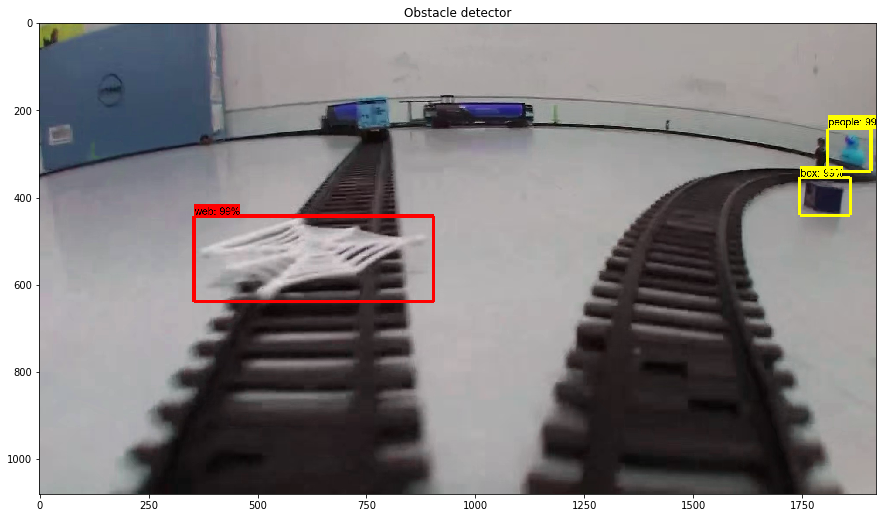

In [61]:
# All the results have been drawn on image. Now display the image.
plt.figure(figsize=(15, 20))

plt.imshow(image)
plt.title('Obstacle detector')
# Press any key to close the image
cv2.waitKey(0)

# Estimate Risk Value By Both Models

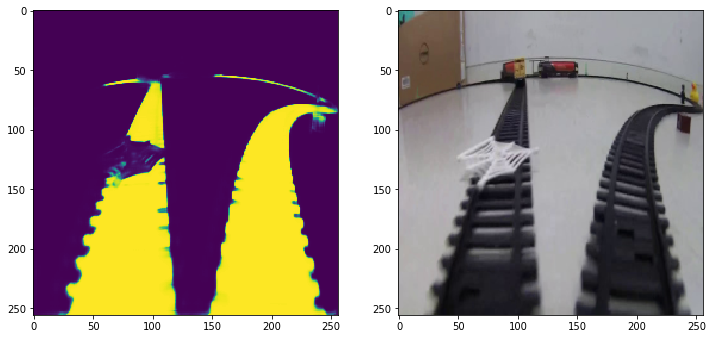

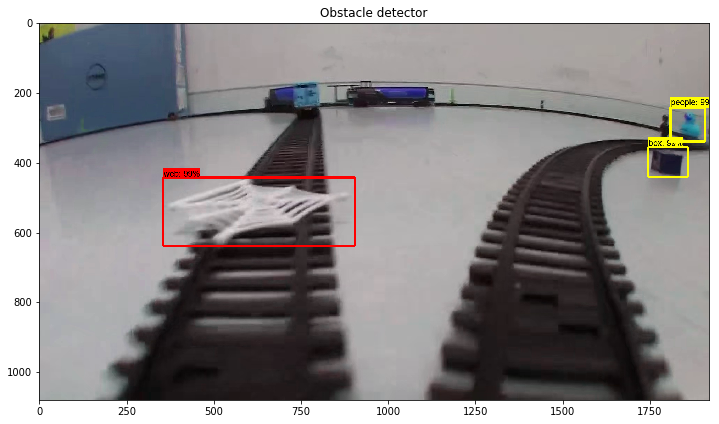

In [62]:
test_img =mpimg.imread(img_path)
squared_img = cv2.resize(test_img, dsize=(256, 256), interpolation=cv2.INTER_AREA) /255
input_img= np.expand_dims(squared_img, axis=0)
predicted_label = model.predict(input_img)[0]
plt.figure(figsize=(12, 18))
plt.subplot(1, 2, 1)
plt.imshow(predicted_label[:, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(squared_img)

final_img = cv2.resize(predicted_label[:, :, 0], dsize=(im_width,im_height), interpolation=cv2.INTER_AREA)


plt.figure(figsize=(12, 15))
plt.imshow(image)
plt.title('Obstacle detector')


#      (left, right, top, bottom) = (xmin * width, xmax * width, ymin * height, ymax * height)
for i in boxdata:
    (ymin, xmin, ymax, xmax) = i[0]
    (top, left, bottom, right) = (ymin * im_height, xmin * im_width,  ymax * im_height, xmax * im_width)
    (top, left, bottom, right) = (top.astype(np.int32), left.astype(np.int32), bottom.astype(np.int32), right.astype(np.int32))
    print(top, left, bottom, right)

    sum = 0
    for iter in range(left,right):
        sum += final_img[bottom][iter]
    print('danger_score : ' , sum/(right-left), i[1])
    danger_score = sum/(right-left)
    if danger_score > 0.7:
        danger_color = 'red'
    elif danger_score > 0.3:
        danger_color = 'orange'
    else:
        danger_color = 'yellow'
    
vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    color=box_to_color_map,
    use_normalized_coordinates=True,
    line_thickness=7,
    min_score_thresh=0.75);
    
